# LSTM Model

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [53]:
class LSTM_Model:
  def prepare_company_data(self, df, features, target='Target', sequence_length=4):

      # Initialize lists to store sequences
      X_sequences = []
      y_values = []
      company_indices = []  # To track which company each sequence belongs to

      # Get unique companies
      companies = df['Company'].unique()

      # Process each company separately
      for company in companies:
          company_data = df[df['Company'] == company].copy()
          company_data = company_data.sort_values('Date')

          # Extract features and target
          feature_data = company_data[features].values
          target_data = company_data[target].values

          # Normalize features for this company
          scaler = StandardScaler()
          feature_data = scaler.fit_transform(feature_data)

          # Create sequences
          for i in range(len(company_data) - sequence_length):
              X_sequences.append(feature_data[i:i+sequence_length])
              y_values.append(target_data[i+sequence_length])
              company_indices.append(company)

      # Convert to numpy arrays
      X = np.array(X_sequences)
      y = np.array(y_values)

      # Split data - use time-based split (last 20% of each company's data for testing)
      train_indices = []
      test_indices = []

      current_idx = 0
      for company in companies:
          company_count = company_indices.count(company)
          if company_count > 0:
              split_idx = int(company_count * 0.8)
              train_indices.extend(range(current_idx, current_idx + split_idx))
              test_indices.extend(range(current_idx + split_idx, current_idx + company_count))
              current_idx += company_count

      X_train = X[train_indices]
      y_train = y[train_indices]
      X_test = X[test_indices]
      y_test = y[test_indices]

      print(f"Prepared {len(X_train)} training sequences and {len(X_test)} testing sequences")

      return X_train, X_test, y_train, y_test

  def create_lstm_model(self, input_shape, lstm_units=50, dropout_rate=0.2, learning_rate=0.01):
    model = Sequential()
    model.add(LSTM(units=lstm_units,
                  return_sequences=True,
                  input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units//2,
                  return_sequences=True))
    model.add(LSTM(units=lstm_units,
                  return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

  def train_and_evaluate_lstm(self, df, features, target='Target', sequence_length=4,
                           lstm_units=50, dropout_rate=0.2, epochs=50, batch_size=16, early_stop_patience = 10, learning_rate=0.01):
    # Prepare data
    X_train, X_test, y_train, y_test = self.prepare_company_data(
        df, features, target, sequence_length)

    # Create model
    model = self.create_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=early_stop_patience,
        restore_best_weights=True
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    # Detailed classification metrics
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, history, {
        'loss': loss,
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

  def predict_next_quarter(self, model, company_data, features, sequence_length=4):
    """
    Predict the next quarter's stock direction for a specific company.
    """
    # Extract the most recent sequence
    recent_data = company_data[features].tail(sequence_length).values

    # Normalize the data
    scaler = StandardScaler()
    recent_data = scaler.fit_transform(recent_data)

    # Reshape for LSTM input [samples, time steps, features]
    X = recent_data.reshape(1, sequence_length, len(features))

    # Make prediction
    prediction = model.predict(X)[0][0]

    return prediction

In [57]:
company_data_df = pd.read_csv("dataset_preprocessed.csv", usecols=["Date", "Company", "Price", "Revenue", "Free cash flow", "Total Debt", "ROE", "EPS", "PE ratio", "Target"])
company_data_df= company_data_df.sort_values(by=["Company", "Date"])

In [58]:
features = ["Price", "Revenue", "Free cash flow", "Total Debt", "ROE", "EPS", "PE ratio"]

In [59]:
lstm = LSTM_Model()

### Set 1:
LSTM model with below parameters:

LSTM Units: 50

batch size: 16

sequence length: 4

early stop patience: 5

dropout rate: 0.2

learning rate: 0.001

epochs: 50


Prepared 15048 training sequences and 3762 testing sequences
Epoch 1/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6081 - loss: 0.6629 - val_accuracy: 0.6169 - val_loss: 0.6513
Epoch 2/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6296 - loss: 0.6478 - val_accuracy: 0.6226 - val_loss: 0.6477
Epoch 3/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6262 - loss: 0.6462 - val_accuracy: 0.6246 - val_loss: 0.6453
Epoch 4/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6444 - loss: 0.6376 - val_accuracy: 0.6399 - val_loss: 0.6443
Epoch 5/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6500 - loss: 0.6329 - val_accuracy: 0.6468 - val_loss: 0.6420
Epoch 6/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6550 - loss: 0.6339 - val_accuracy: 0.6352 - val_loss: 0.6339
Epoch 7/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6530 - loss: 0.6301 - val_accuracy: 0.6535 - val_loss: 0.6313
Epoch 8/50
753/753 ━━━━━━━━━━━━━━━━━━━━ 5s 

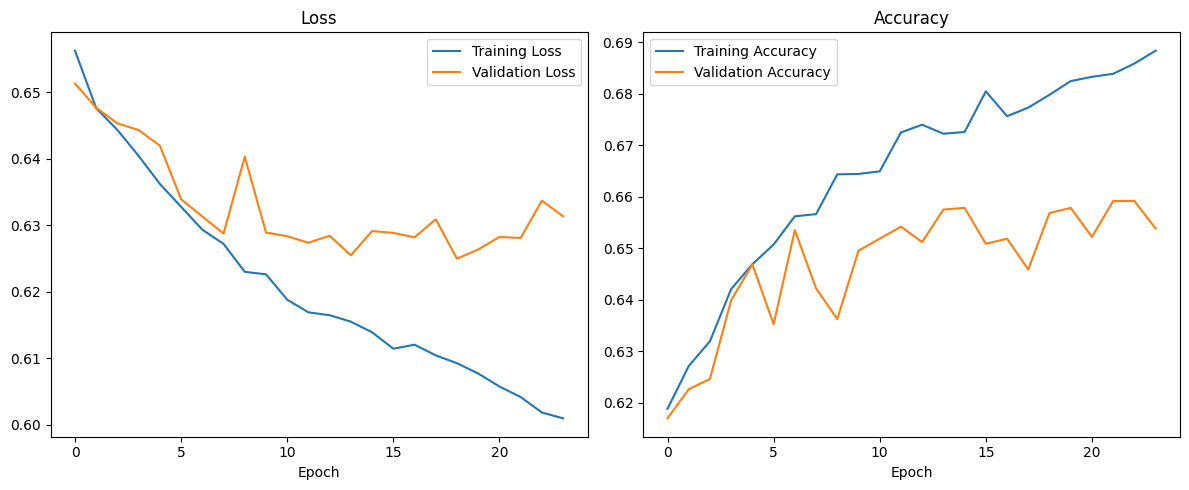

(<Sequential name=sequential, built=True>,
 {'loss': 0.7337209582328796,
  'accuracy': 0.540669858455658,
  'classification_report': {'0': {'precision': 0.4332833583208396,
    'recall': 0.5934291581108829,
    'f1-score': 0.5008665511265165,
    'support': 1461.0},
   '1': {'precision': 0.6626916524701874,
    'recall': 0.5071707953063885,
    'f1-score': 0.5745937961595273,
    'support': 2301.0},
   'accuracy': 0.5406698564593302,
   'macro avg': {'precision': 0.5479875053955134,
    'recall': 0.5502999767086357,
    'f1-score': 0.5377301736430219,
    'support': 3762.0},
   'weighted avg': {'precision': 0.5735992766721552,
    'recall': 0.5406698564593302,
    'f1-score': 0.545961285528685,
    'support': 3762.0}},
  'confusion_matrix': array([[ 867,  594],
         [1134, 1167]])})

In [17]:
lstm_model, history, evaluation = lstm.train_and_evaluate_lstm(company_data_df, features, target='Target', sequence_length=4,
                           lstm_units=50, dropout_rate=0.2, epochs=50, batch_size=16, early_stop_patience = 5)

### Set 2:
LSTM model with below parameters:

LSTM Units: 64

batch size: 32

sequence length: 4

early stop patience: 5

dropout rate: 0.2

learning rate: 0.001

epochs: 100

Prepared 15048 training sequences and 3762 testing sequences
Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5994 - loss: 0.6621 - val_accuracy: 0.6130 - val_loss: 0.6509
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6316 - loss: 0.6453 - val_accuracy: 0.6239 - val_loss: 0.6491
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6327 - loss: 0.6449 - val_accuracy: 0.6302 - val_loss: 0.6397
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6434 - loss: 0.6382 - val_accuracy: 0.6399 - val_loss: 0.6339
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6495 - loss: 0.6351 - val_accuracy: 0.6419 - val_loss: 0.6333
Epoch 6/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6565 - loss: 0.6295 - val_accuracy: 0.6359 - val_loss: 0.6325
Epoch 7/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6556 - loss: 0.6274 - val_accuracy: 0.6465 - val_loss: 0.6323
Epoch 8/100
377/377 ━━━━━━━━━━━━━━━━

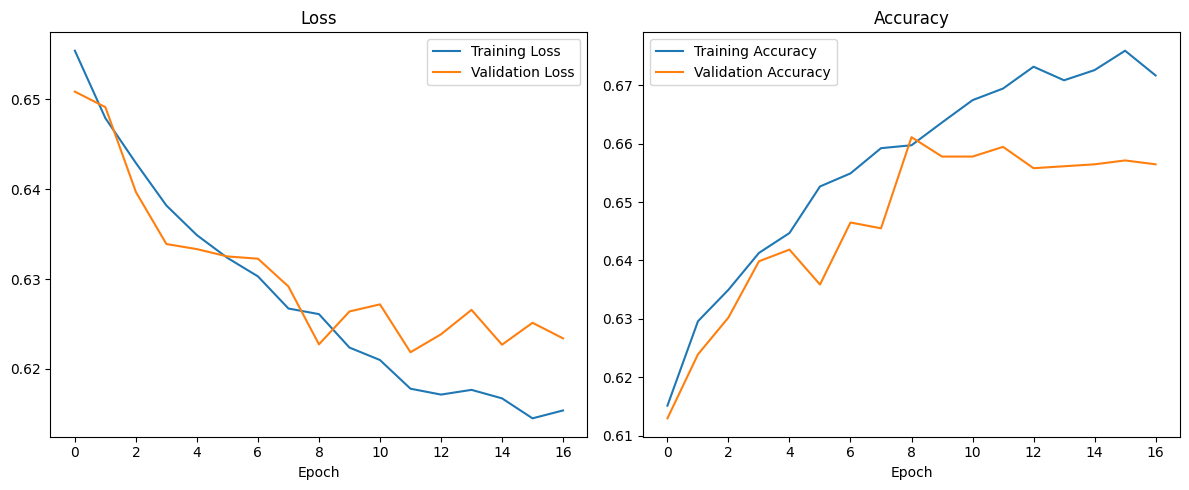

In [20]:
lstm_model, history, evaluation = lstm.train_and_evaluate_lstm(company_data_df, features, target='Target', sequence_length=4,
                           lstm_units=64, dropout_rate=0.2, epochs=100, batch_size=32, early_stop_patience = 5)

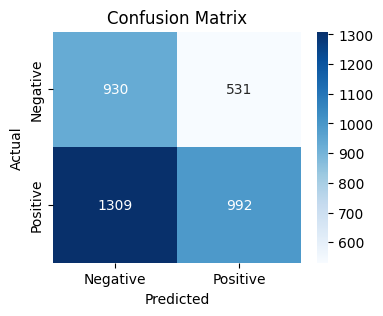

In [37]:
# Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(4, 3))
sns.heatmap(evaluation['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### Final results, next quarter prediction from Set 2 training below

In [24]:
# Example: Make predictions for each company's next quarter
for company in company_data_df['Company'].unique():
    company_data = company_data_df[company_data_df['Company'] == company]

    if len(company_data) >= 4:  # Need at least 4 quarters of data
        prob = lstm.predict_next_quarter(lstm_model, company_data, features)
        direction = "UP" if prob > 0.5 else "DOWN"
        print(f"{company}: {prob:.2f} probability of going {direction} next quarter")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Company_001: 0.50 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Company_002: 0.40 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Company_003: 0.86 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Company_004: 0.08 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Company_005: 0.86 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Company_006: 0.09 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Company_007: 0.84 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Company_008: 0.11 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Company_009: 0.16 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Company_010: 0.85 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Company_011: 0.22 prob

### Set 3:
LSTM model with below parameters:

LSTM Units: 64

batch size: 16

sequence length: 4

early stop patience: 10

dropout rate: 0.2

learning rate: 0.01

epochs: 100

Prepared 15048 training sequences and 3762 testing sequences
Epoch 1/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6037 - loss: 0.6698 - val_accuracy: 0.5997 - val_loss: 0.6651
Epoch 2/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6182 - loss: 0.6602 - val_accuracy: 0.6166 - val_loss: 0.6596
Epoch 3/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6326 - loss: 0.6487 - val_accuracy: 0.6442 - val_loss: 0.6503
Epoch 4/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6337 - loss: 0.6469 - val_accuracy: 0.6412 - val_loss: 0.6438
Epoch 5/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6500 - loss: 0.6300 - val_accuracy: 0.6422 - val_loss: 0.6351
Epoch 6/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6615 - loss: 0.6303 - val_accuracy: 0.6468 - val_loss: 0.6349
Epoch 7/100
753/753 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6650 - loss: 0.6267 - val_accuracy: 0.6485 - val_loss: 0.6377
Epoch 8/100
753/753 ━━━━━━━━━━━━━━━

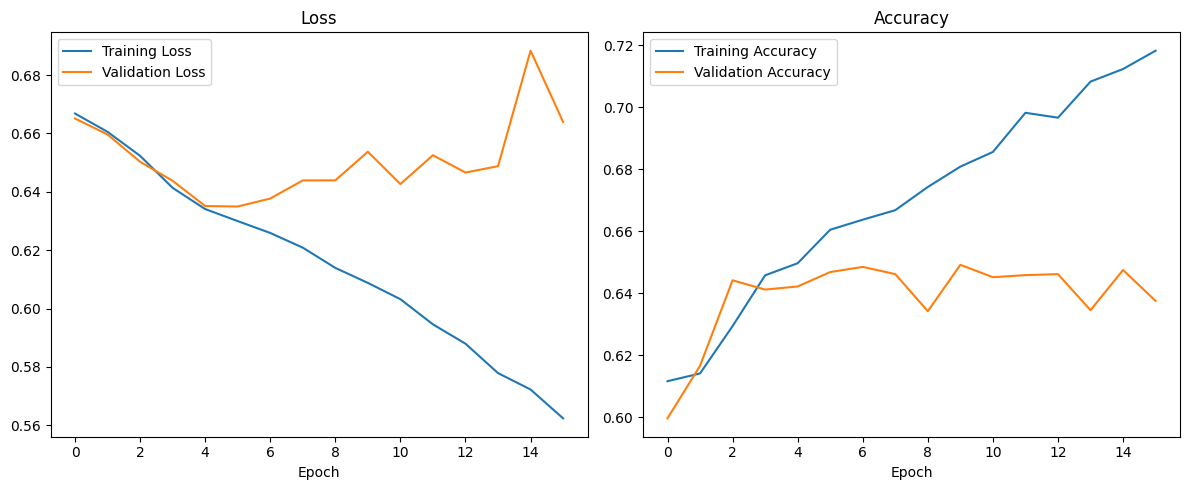

In [60]:
lstm_model, history, evaluation = lstm.train_and_evaluate_lstm(company_data_df, features, target='Target', sequence_length=4,
                           lstm_units=64, dropout_rate=0.2, epochs=100, batch_size=16, early_stop_patience=10, learning_rate=0.01)

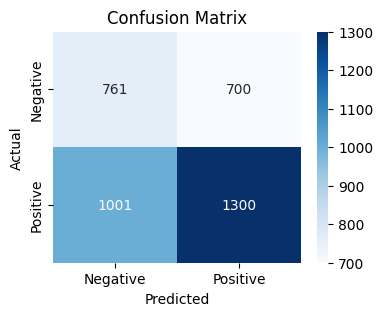

In [61]:
import seaborn as sns
plt.figure(figsize=(4, 3))
sns.heatmap(evaluation['confusion_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### Final results, next quarter prediction from Set 3 training below

In [62]:
# Example: Make predictions for each company's next quarter
for company in company_data_df['Company'].unique():
    company_data = company_data_df[company_data_df['Company'] == company]

    if len(company_data) >= 4:  # Need at least 4 quarters of data
        prob = lstm.predict_next_quarter(lstm_model, company_data, features)
        direction = "UP" if prob > 0.5 else "DOWN"
        print(f"{company}: {prob:.2f} probability of going {direction} next quarter")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Company_001: 0.33 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Company_002: 0.68 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Company_003: 0.74 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Company_004: 0.20 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Company_005: 0.78 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Company_006: 0.19 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Company_007: 0.77 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Company_008: 0.25 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Company_009: 0.28 probability of going DOWN next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Company_010: 0.76 probability of going UP next quarter
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Company_011: 0.31 prob

In [ ]:
# Save the model
lstm_model.save('stock_direction_lstm_model.h5')